robotiqGymEnv __init__
robot base reset
robot base reset
xvel:  -0.033523744949321685
yvel:  0.2731250842882109
zvel:  0.16276757723656976


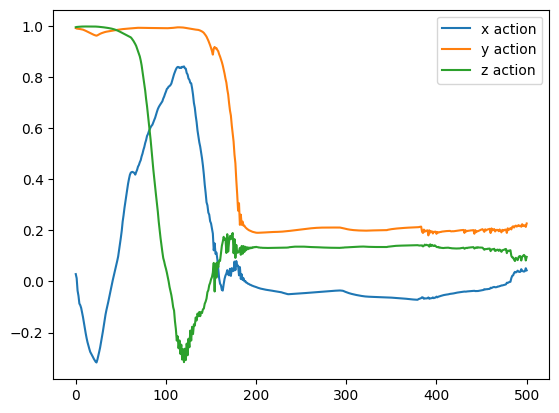

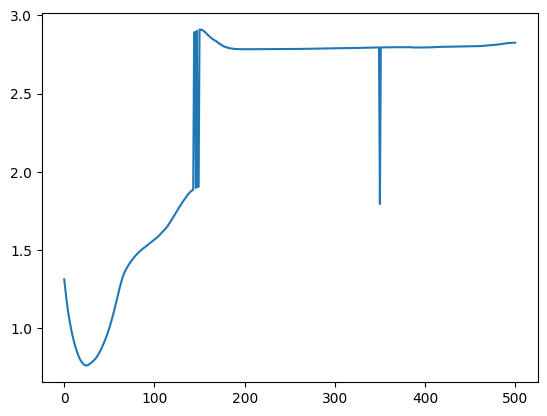

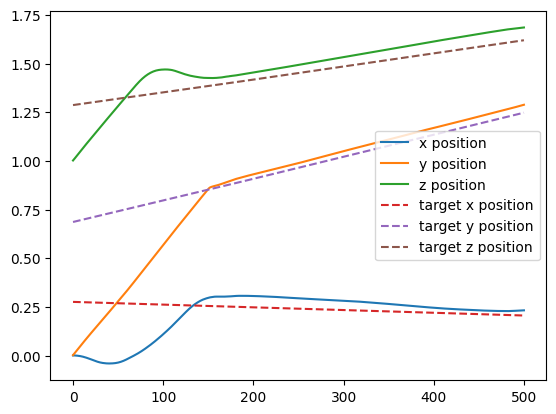

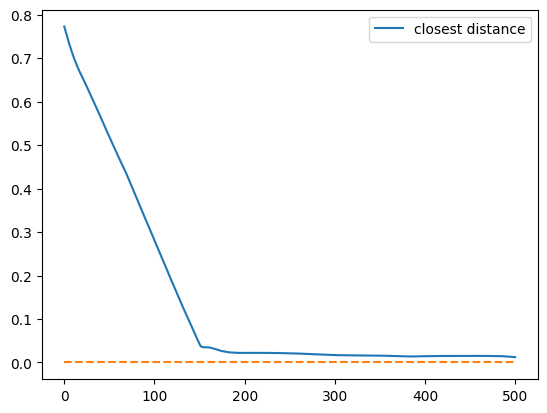

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
# from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from robotiqGymEnv import robotiqGymEnv
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy


def main():

    env = robotiqGymEnv(records=False, renders=False)

    dir = "models/20230304-05:35PM_SAC_M1000_0.04_wovel/best_model.zip"
    model = SAC.load(dir)

    # mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    # print(mean_reward)

    t_ = np.array([])
    rewards_ = np.array([])
    xaction_ = np.array([])
    yaction_ = np.array([])
    zaction_ = np.array([])
    xposition_ = np.array([])
    yposition_ = np.array([])
    zposition_ = np.array([])
    targetxposition_ = np.array([])
    targetyposition_ = np.array([])
    targetzposition_ = np.array([])
    closestpoint_ = np.array([])


    dones = False
    obs = env.reset()

    while not dones:
        t_ = np.append(t_, env._envStepCounter)
        #   action = [0 , 0 , 0 , 0 , 0 , 0 , 0.1]
        # else:
        #   action = [0 , 0 , 0 , 1 , 0 , 1 , 1]
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)

        rewards_ = np.append(rewards_,env._reward())
        xaction_ = np.append(xaction_,action[0])
        yaction_ = np.append(yaction_,action[1])
        zaction_ = np.append(zaction_,action[2])
        xposition_ = np.append(xposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][0])
        yposition_ = np.append(yposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][1])
        zposition_ = np.append(zposition_ , p.getBasePositionAndOrientation(env._robotiq.robotiqUid)[0][2])
        targetxposition_ = np.append(targetxposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][0])
        targetyposition_ = np.append(targetyposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][1] - 0.2)
        targetzposition_ = np.append(targetzposition_ , p.getBasePositionAndOrientation(env.blockUid)[0][2])
        closestpoint_ = np.append(closestpoint_ , p.getClosestPoints(env._robotiq.robotiqUid, env.blockUid, 100, -1, -1)[0][8])
        xtargetvel = p.getBaseVelocity(env.blockUid)[0][0]
        ytargetvel = p.getBaseVelocity(env.blockUid)[0][1]
        ztargetvel = p.getBaseVelocity(env.blockUid)[0][2]
        # env.render()
        # time.sleep(0.1)


    plt.plot(xaction_, label="x action")
    plt.plot(yaction_, label="y action")
    plt.plot(zaction_, label="z action")
    plt.legend()

    print("xvel: ", xtargetvel)
    print("yvel: ", ytargetvel)
    print("zvel: ", ztargetvel)

    plt.figure()
    plt.plot(rewards_, label="reward")

    plt.figure()
    plt.plot(xposition_, label="x position")
    plt.plot(yposition_, label="y position")
    plt.plot(zposition_, label="z position")

    plt.plot(targetxposition_, label="target x position", linestyle='--')
    plt.plot(targetyposition_, label="target y position", linestyle='--')
    plt.plot(targetzposition_, label="target z position", linestyle='--')
    plt.legend()

    plt.figure()
    plt.plot(closestpoint_, label="closest distance")
    plt.plot(np.zeros(len(closestpoint_)), linestyle='--')
    plt.legend()
  



if __name__ == "__main__":
  main()